<a href="https://www.kaggle.com/code/tornikeonoprishvili/fdtd-simulating-drude-lorentz-dispersion-in-silver?scriptVersionId=100540912" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

The following notebook will rely on information from the following paper ([download](https://www.mdpi.com/2072-666X/3/1/168/pdf)), `"Effective Permittivity for FDTD Calculation of Plasmonic Materials"` by Naoki Okada and James B. Cole. 

The paper discusses the problems the simulating metals in using the usual, staircase approximations in FDTD. It shows that for curved surfaces, staircase FDTD needs to use very fine grid in order to avoid a diverging simulation. We'll explore their results and replicate their results in 2d, using the `pymeep` library for simulation.

In [1]:
!conda install -y -c conda-forge pymeep pymeep-extras seaborn

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pymeep
    - pymeep-extras
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aom-3.3.0                  |       h27087fc_1         2.6 MB  conda-forge
    autograd-1.4               |     pyhd8ed1ab_0          42 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  c

In [2]:
%matplotlib inline

import os
import meep as mp
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime 
from meep import materials as unscaled_materials # 

In [3]:
# scale is nanometer
nm = 1
scale_factor = nm
um = 1000 * nm

**BUG Alert**: Meep requires to manually change scale of materials.py in order to work with different scales. The default scale is micrometer (1e-6), we need nanometer (1e-9). So, we'll copy the `materials.py` file locally, and `sed`-in the correction term on line 9, like this:

In [4]:
!rm -rf scaled_materials.py
!cp {unscaled_materials.__file__} scaled_materials.py
print('=================== Before ===================')
!head -n 9 scaled_materials.py
sed_command = f'9i um_scale = {scale_factor / um} * um_scale'
!sed -i '{sed_command}' scaled_materials.py
print('=================== After ====================')
!head -n 9 scaled_materials.py

=================== Before ===================
# -*- coding: utf-8 -*-
# Materials Library

import meep as mp
import numpy as np

# default unit length is 1 μm
um_scale = 1.0

=================== After ====================
# -*- coding: utf-8 -*-
# Materials Library

import meep as mp
import numpy as np

# default unit length is 1 μm
um_scale = 1.0
um_scale = 0.001 * um_scale


We find the specifications figure in the paper:

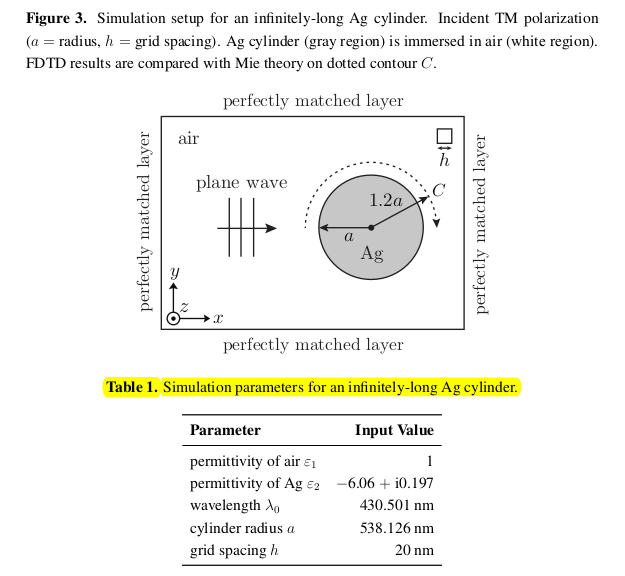

So, here's what we think right away:
- 2D simulation, cylinder at (0,0)
- Default material is air (eps = 1.0)
- Cylinder material is elemental Silver (Ag), which is present in the meep library, so no need to manually use the $\epsilon_2 = −6.06 + i0.197$ value. 
- Wavelength is $\lambda_0 = 430.501nm$ with meep's scaling features, we'll just use number $430.501$. 
- Cylider radius is given same treatment as wavelength
- Grid spacing is a bit tricky - meep's `resolution` variable means "pixels per unit distance", so pixels per nanometer. Grid spacing is inverse of that, units of distance per pixel. So, $resolution = 1/h$.

**BUG ALERT**: Careful with the resolution! Read the following figure from the paper:


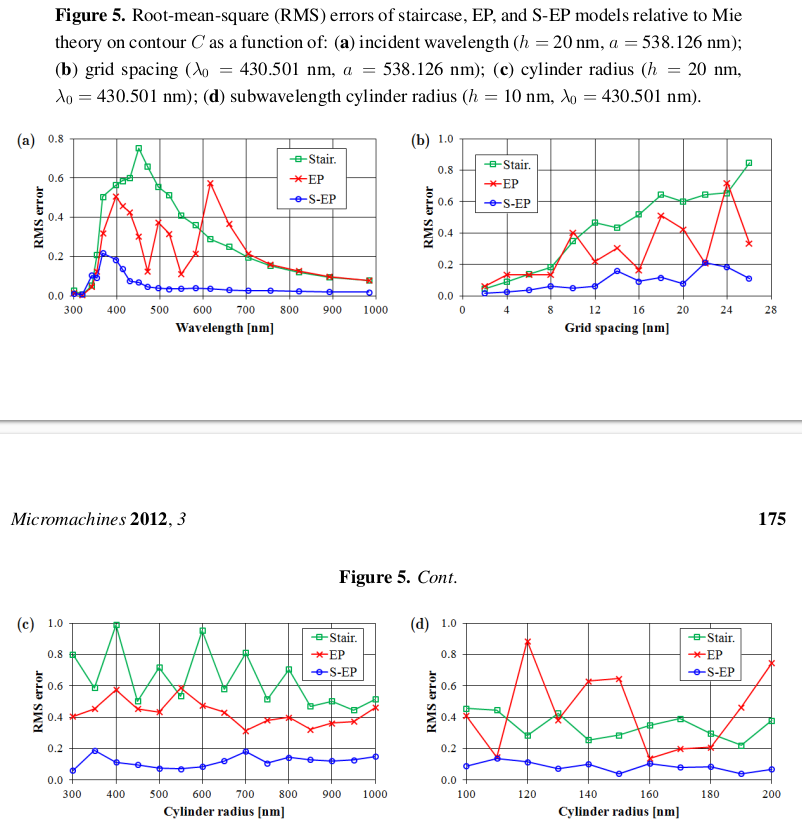


See this diagram here (figure b). It uses our parameters and on the x axis, varies the grid spacing (i.e. 1/meep_resoultion). We are using the staircase (green squares) approach. See that the RMS error rapidly increases after Grid spacing $h > 8nm$. Other figures, show that with $h = 20nm$, the only way to avoid high error and divergence is to either use bigger the wavelegth (figure a), use bigger cylinder (doesn't help much) (figure c), or use cylinder that's at at most twice as small as the given wavelength (figure d). 

The resolution can be at most 8um/pixel!

First, let's set a basic simulation and then make it into a function for easier looping over args.

In [5]:
wavelength = 430.501 # lambda_0, wavelength of source
# Currently 
# Note that usually, h can be at most 1/20 of wavelength
# Now, with plasmonic curved surfaces, it has to be even smaller 
# Otherwise the simulation will diverge
# h = 20 # DIVERGES!
h = 8  # grid spacing - doesn't diverge
# a = 1.25 * wavelength
a = 538.126 # cylinder radius
dpml = 1.0 * wavelength # pml width has to be at least one wavelength
size = a * 2 + wavelength * 2 + dpml * 2 # full grid size
resolution = 1 / h # pixels per unit of distance

In [6]:
print('pixels per wavelength',wavelength / h)
print('Usually has to be >20, but in this case has to be higher (see figure 1, b above)')
print('total size in pixels', resolution * size)

pixels per wavelength 53.812625
Usually has to be >20, but in this case has to be higher (see figure 1, b above)
total size in pixels 349.782


-----------
Initializing structure...
time for choose_chunkdivision = 0.00039196 s
Working in 2D dimensions.
Computational cell is 2800 x 2800 x 0 with resolution 0.125
     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.259709 s
lorentzian susceptibility: frequency=0.016365, gamma=0.00195106
lorentzian susceptibility: frequency=0.00732593, gamma=0.000738804
lorentzian susceptibility: frequency=0.00660165, gamma=5.2426e-05
lorentzian susceptibility: frequency=0.00361417, gamma=0.000364563
lorentzian susceptibility: frequency=0.000658148, gamma=0.00313427
drude susceptibility: frequency=1e-10, gamma=3.87146e-05
-----------


FloatProgress(value=0.0, description='0% done ', max=10000.0)

     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


/opt/conda/lib/python3.7/site-packages/meep/visualization.py:413: UserWarning: No contour levels were found within the data range.
  ax.contour(eps_data, 0, levels=np.unique(eps_data), colors='black', origin='upper', extent=extent, linewidths=eps_parameters['contour_linewidth'])


Meep progress: 2924.0/10000.0 = 29.2% done in 4.0s, 9.7s to go
on time step 734 (time=2936), 0.00545237 s/step
Meep progress: 6188.0/10000.0 = 61.9% done in 8.0s, 4.9s to go
on time step 1550 (time=6200), 0.00504402 s/step
Meep progress: 9324.0/10000.0 = 93.2% done in 12.0s, 0.9s to go
on time step 2356 (time=9424), 0.00504991 s/step
run 0 finished at t = 10000.0 (2500 timesteps)
Generating MP4...


     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


<AxesSubplot:xlabel='X', ylabel='Y'>

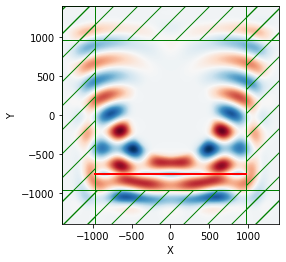

In [7]:
from scaled_materials import Ag, Au

cell_size = mp.Vector3(size,size)
boundary_layers = [mp.PML(thickness=dpml,
                          direction=mp.ALL)]

# epsilon_complex = -6.06 + 0.197j
# omega = 1/wavelength
# omega_plasma = omega * ( (( 1 - epsilon_complex.real) ** 2 + epsilon_complex.imag ** 2)
#                          / (1 - epsilon_complex.real)) ** .5
# coll_freq = omega * (epsilon_complex.imag / (1 - epsilon_complex.real))
# E_susceptibilities = [mp.DrudeSusceptibility(
#     frequency=omega_plasma,sigma=1,gamma=coll_freq)]
# material = mp.Medium(epsilon=1, 
#                      E_susceptibilities=E_susceptibilities)


geometry = [mp.Cylinder(radius=a,
                        center=mp.Vector3(0,0,0), 
                        material=Ag)]
# geometry = [
#     mp.Block(
#         size=mp.Vector3(2 * a, 2 * a, mp.inf),
#         center=mp.Vector3(0,0,0)
#     )
# ]

sources = [
    mp.Source(
        src=mp.ContinuousSource(wavelength=wavelength, 
                                width=2 * wavelength),
        center=mp.Vector3(0, -size/2 + dpml + wavelength/2, 0),
        size=mp.Vector3(size - dpml*2,0,0),
        component=mp.Ez,
    )
]


sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
#                     k_point=beam_kdir,
                    sources=sources,
                   )

f = plt.figure(figsize = (8,8))
animation = mp.Animate2D(sim, mp.Ez, f=f, eps_parameters=dict(contour=True))

plt.close()
t_steps = 10000
fps = 4
anim_seconds = 10
anim_frames = anim_seconds * fps
sim.run(
    mp.at_every(t_steps / anim_frames, animation),
    until=t_steps
)

animation.to_mp4(fps, 'animation.mp4')

sim.plot2D(fields=mp.Ez)

# plt.savefig('Ez_angle{}.png'.format(rot_angle),bbox_inches='tight',pad_inches=0)

In [8]:
from IPython.display import Video
Video('animation.mp4')

Let's simulate over a range of values for $h$. We expect simulation to be stable below $h < 8$, and unstable above that:

In [9]:
from scaled_materials import Ag, Au


#  epsilon_complex = -6.06 + 0.197j,

def simulate(
    wavelength = 430.501, # lambda_0, wavelength of source
    h = 8,
    a = 538.126, # cylinder radius
    t_steps = 10000,
    material: mp.Medium = Ag, # Either of the two, not both.
    epsilon_complex: complex = None,
):
    resolution = 1 / h
    dpml = 1.0 * wavelength
    size = a * 2 + wavelength * 2 + dpml * 2
    input_args = dict(locals())
    
    time_now  = datetime.datetime.now().strftime('%m_%d_%Y_%H_%M_%S') 
    sim_name = '_'.join([str(k)+'='+str(v) for k,v in input_args.items()]) + '_' + time_now
    
    print('pixels per wavelength',wavelength / h)
    print('Usually has to be >20, but in this case has to be higher (see figure 1, b above)')
    print('total size in pixels', resolution * size)

    cell_size = mp.Vector3(size,size)
    boundary_layers = [mp.PML(thickness=dpml,
                              direction=mp.ALL)]
    
    if epsilon_complex:
        omega = 1/wavelength
        omega_plasma = omega * ( (( 1 - epsilon_complex.real) ** 2 + epsilon_complex.imag ** 2)
                                 / (1 - epsilon_complex.real)) ** .5
        coll_freq = omega * (epsilon_complex.imag / (1 - epsilon_complex.real))
        E_susceptibilities = [mp.DrudeSusceptibility(
            frequency=omega_plasma,sigma=1,gamma=coll_freq)]
        material = mp.Medium(epsilon=1, 
                             E_susceptibilities=E_susceptibilities)

    geometry = [mp.Cylinder(radius=a,
                            center=mp.Vector3(0,0,0), 
                            material=material)]
#     geometry = [
#         mp.Block(
#             size=mp.Vector3(2 * a, 2 * a, mp.inf),
#             center=mp.Vector3(0,0,0)
#         )
#     ]

    sources = [
        mp.Source(
            src=mp.ContinuousSource(wavelength=wavelength, 
                                    width=2 * wavelength),
            center=mp.Vector3(0, -size/2 + dpml + wavelength/2, 0),
            size=mp.Vector3(size - dpml*2,0,0),
            component=mp.Ez,
        )
    ]


    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=boundary_layers,
                        geometry=geometry,
                        sources=sources,
                       )

    f = plt.figure(figsize = (8,8))
    animation = mp.Animate2D(sim, mp.Ez, f=f, eps_parameters=dict(contour=True))

    plt.close()
    
    fps = 4
    anim_seconds = 10
    anim_frames = anim_seconds * fps
    os.makedirs('ouput',exist_ok=True)
    animfname = f'ouput/{sim_name}.mp4'
    
    try:
        sim.run(
            mp.at_every(t_steps / anim_frames, animation),
            until=t_steps
        )    
    except RuntimeError as e:
        errormsg = e
        print(e)
    finally:
        animation.to_mp4(fps, animfname)
        sim.plot2D(fields=mp.Ez)
        return dict(locals()) # Return it all

  0%|          | 0/6 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


pixels per wavelength 107.62525
Usually has to be >20, but in this case has to be higher (see figure 1, b above)
total size in pixels 699.564
-----------
Initializing structure...
time for choose_chunkdivision = 0.00108099 s
Working in 2D dimensions.
Computational cell is 2800 x 2800 x 0 with resolution 0.25
     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.943899 s
lorentzian susceptibility: frequency=0.016365, gamma=0.00195106
lorentzian susceptibility: frequency=0.00732593, gamma=0.000738804
lorentzian susceptibility: frequency=0.00660165, gamma=5.2426e-05
lorentzian susceptibility: frequency=0.00361417, gamma=0.000364563
lorentzian susceptibility: frequency=0.000658148, gamma=0.00313427
drude susceptibility: frequency=1e-10, gamma=3.87146e-05
-----------


FloatProgress(value=0.0, description='0% done ', max=100000.0)

Meep progress: 556.0/100000.0 = 0.6% done in 4.0s, 716.9s to go
on time step 279 (time=558), 0.0143887 s/step
Meep progress: 1140.0/100000.0 = 1.1% done in 8.0s, 694.7s to go
on time step 571 (time=1142), 0.0137015 s/step
Meep progress: 1722.0/100000.0 = 1.7% done in 12.0s, 686.1s to go
on time step 862 (time=1724), 0.01378 s/step
Meep progress: 2280.0/100000.0 = 2.3% done in 16.0s, 687.1s to go
on time step 1141 (time=2282), 0.0143611 s/step


     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


/opt/conda/lib/python3.7/site-packages/meep/visualization.py:413: UserWarning: No contour levels were found within the data range.
  ax.contour(eps_data, 0, levels=np.unique(eps_data), colors='black', origin='upper', extent=extent, linewidths=eps_parameters['contour_linewidth'])


Meep progress: 2550.0/100000.0 = 2.5% done in 20.0s, 765.8s to go
on time step 1276 (time=2552), 0.0296802 s/step
Meep progress: 3126.0/100000.0 = 3.1% done in 24.0s, 745.2s to go
on time step 1564 (time=3128), 0.0139003 s/step
Meep progress: 3696.0/100000.0 = 3.7% done in 28.1s, 730.9s to go
on time step 1849 (time=3698), 0.0140574 s/step
Meep progress: 4264.0/100000.0 = 4.3% done in 32.1s, 719.9s to go
on time step 2133 (time=4266), 0.014122 s/step
Meep progress: 4838.0/100000.0 = 4.8% done in 36.1s, 709.6s to go
on time step 2420 (time=4840), 0.013959 s/step
Meep progress: 5394.0/100000.0 = 5.4% done in 40.1s, 703.0s to go
on time step 2698 (time=5396), 0.0144067 s/step
Meep progress: 5982.0/100000.0 = 6.0% done in 44.1s, 692.9s to go
on time step 2992 (time=5984), 0.0136158 s/step
Meep progress: 6562.0/100000.0 = 6.6% done in 48.1s, 684.8s to go
on time step 3282 (time=6564), 0.0137999 s/step
Meep progress: 7144.0/100000.0 = 7.1% done in 52.1s, 677.1s to go
on time step 3573 (time=

     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


 17%|█▋        | 1/6 [11:45<58:48, 705.65s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


pixels per wavelength 53.812625
Usually has to be >20, but in this case has to be higher (see figure 1, b above)
total size in pixels 349.782
-----------
Initializing structure...
time for choose_chunkdivision = 0.000400066 s
Working in 2D dimensions.
Computational cell is 2800 x 2800 x 0 with resolution 0.125
     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.259539 s
lorentzian susceptibility: frequency=0.016365, gamma=0.00195106
lorentzian susceptibility: frequency=0.00732593, gamma=0.000738804
lorentzian susceptibility: frequency=0.00660165, gamma=5.2426e-05
lorentzian susceptibility: frequency=0.00361417, gamma=0.000364563
lorentzian susceptibility: frequency=0.000658148, gamma=0.00313427
drude susceptibility: frequency=1e-10, gamma=3.87146e-05
-----------


FloatProgress(value=0.0, description='0% done ', max=100000.0)

     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


/opt/conda/lib/python3.7/site-packages/meep/visualization.py:413: UserWarning: No contour levels were found within the data range.
  ax.contour(eps_data, 0, levels=np.unique(eps_data), colors='black', origin='upper', extent=extent, linewidths=eps_parameters['contour_linewidth'])


Meep progress: 3952.0/100000.0 = 4.0% done in 4.0s, 97.3s to go
on time step 991 (time=3964), 0.00404008 s/step
Meep progress: 8624.0/100000.0 = 8.6% done in 8.0s, 84.8s to go
on time step 2160 (time=8640), 0.00342404 s/step
Meep progress: 13244.0/100000.0 = 13.2% done in 12.0s, 78.6s to go
on time step 3315 (time=13260), 0.00346377 s/step
Meep progress: 17768.0/100000.0 = 17.8% done in 16.0s, 74.1s to go
on time step 4447 (time=17788), 0.00353513 s/step
Meep progress: 22500.0/100000.0 = 22.5% done in 20.1s, 69.1s to go
on time step 5625 (time=22500), 0.00341863 s/step
Meep progress: 27096.0/100000.0 = 27.1% done in 24.1s, 64.7s to go
on time step 6774 (time=27096), 0.00348298 s/step
Meep progress: 31688.0/100000.0 = 31.7% done in 28.1s, 60.5s to go
on time step 7923 (time=31692), 0.00348178 s/step
Meep progress: 36304.0/100000.0 = 36.3% done in 32.1s, 56.2s to go
on time step 9077 (time=36308), 0.00346627 s/step
Meep progress: 40688.0/100000.0 = 40.7% done in 36.1s, 52.6s to go
on tim

     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


 33%|███▎      | 2/6 [13:15<22:54, 343.59s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


pixels per wavelength 35.87508333333333
Usually has to be >20, but in this case has to be higher (see figure 1, b above)
total size in pixels 233.188
-----------
Initializing structure...
time for choose_chunkdivision = 0.000302076 s
Working in 2D dimensions.
Computational cell is 2796 x 2796 x 0 with resolution 0.0833333
     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.129554 s
lorentzian susceptibility: frequency=0.016365, gamma=0.00195106
lorentzian susceptibility: frequency=0.00732593, gamma=0.000738804
lorentzian susceptibility: frequency=0.00660165, gamma=5.2426e-05
lorentzian susceptibility: frequency=0.00361417, gamma=0.000364563
lorentzian susceptibility: frequency=0.000658148, gamma=0.00313427
drude susceptibility: frequency=1e-10, gamma=3.87146e-05
-----------


FloatProgress(value=0.0, description='0% done ', max=100000.0)

     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


/opt/conda/lib/python3.7/site-packages/meep/visualization.py:413: UserWarning: No contour levels were found within the data range.
  ax.contour(eps_data, 0, levels=np.unique(eps_data), colors='black', origin='upper', extent=extent, linewidths=eps_parameters['contour_linewidth'])


Meep progress: 13728.0/100000.0 = 13.7% done in 4.0s, 25.1s to go
on time step 2296 (time=13776), 0.00174231 s/step
Meep progress: 28758.0/100000.0 = 28.8% done in 8.0s, 19.8s to go
on time step 4802 (time=28812), 0.00159622 s/step
Meep progress: 43386.0/100000.0 = 43.4% done in 12.0s, 15.7s to go
on time step 7241 (time=43446), 0.0016403 s/step
Meep progress: 58326.0/100000.0 = 58.3% done in 16.0s, 11.4s to go
on time step 9732 (time=58392), 0.0016062 s/step
Meep progress: 73632.0/100000.0 = 73.6% done in 20.0s, 7.2s to go
on time step 12284 (time=73704), 0.00156742 s/step
Meep progress: 88758.0/100000.0 = 88.8% done in 24.0s, 3.0s to go
on time step 14805 (time=88830), 0.00158695 s/step
run 0 finished at t = 100002.0 (16667 timesteps)
Generating MP4...


     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


 50%|█████     | 3/6 [13:43<09:58, 199.57s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


pixels per wavelength 30.750071428571427
Usually has to be >20, but in this case has to be higher (see figure 1, b above)
total size in pixels 199.87542857142856
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 2D dimensions.
Computational cell is 2800 x 2800 x 0 with resolution 0.0714286
     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.101191 s
lorentzian susceptibility: frequency=0.016365, gamma=0.00195106
lorentzian susceptibility: frequency=0.00732593, gamma=0.000738804
lorentzian susceptibility: frequency=0.00660165, gamma=5.2426e-05
lorentzian susceptibility: frequency=0.00361417, gamma=0.000364563
lorentzian susceptibility: frequency=0.000658148, gamma=0.00313427
drude susceptibility: frequency=1e-10, gamma=3.87146e-05
-----------


FloatProgress(value=0.0, description='0% done ', max=100000.0)

     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


/opt/conda/lib/python3.7/site-packages/meep/visualization.py:413: UserWarning: No contour levels were found within the data range.
  ax.contour(eps_data, 0, levels=np.unique(eps_data), colors='black', origin='upper', extent=extent, linewidths=eps_parameters['contour_linewidth'])


Meep progress: 20650.0/100000.0 = 20.6% done in 4.0s, 15.4s to go
on time step 2958 (time=20706), 0.0013523 s/step
Meep progress: 42483.0/100000.0 = 42.5% done in 8.0s, 10.8s to go
on time step 6073 (time=42511), 0.0012843 s/step
Meep progress: 64974.0/100000.0 = 65.0% done in 12.1s, 6.5s to go
on time step 9282 (time=64974), 0.00126614 s/step
Meep progress: 86975.0/100000.0 = 87.0% done in 16.1s, 2.4s to go
on time step 12426 (time=86982), 0.00127248 s/step
run 0 finished at t = 100002.0 (14286 timesteps)
Generating MP4...


     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


 67%|██████▋   | 4/6 [14:03<04:17, 128.67s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


pixels per wavelength 26.9063125
Usually has to be >20, but in this case has to be higher (see figure 1, b above)
total size in pixels 174.891
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 2D dimensions.
Computational cell is 2800 x 2800 x 0 with resolution 0.0625
     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.08392 s
lorentzian susceptibility: frequency=0.016365, gamma=0.00195106
lorentzian susceptibility: frequency=0.00732593, gamma=0.000738804
lorentzian susceptibility: frequency=0.00660165, gamma=5.2426e-05
lorentzian susceptibility: frequency=0.00361417, gamma=0.000364563
lorentzian susceptibility: frequency=0.000658148, gamma=0.00313427
drude susceptibility: frequency=1e-10, gamma=3.87146e-05
-----------


FloatProgress(value=0.0, description='0% done ', max=100000.0)

     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


/opt/conda/lib/python3.7/site-packages/meep/visualization.py:413: UserWarning: No contour levels were found within the data range.
  ax.contour(eps_data, 0, levels=np.unique(eps_data), colors='black', origin='upper', extent=extent, linewidths=eps_parameters['contour_linewidth'])


Meep progress: 27456.0/100000.0 = 27.5% done in 4.0s, 10.7s to go
on time step 3432 (time=27456), 0.00117494 s/step
Meep progress: 54912.0/100000.0 = 54.9% done in 8.1s, 6.6s to go
on time step 6864 (time=54912), 0.00116861 s/step
Meep progress: 83816.0/100000.0 = 83.8% done in 12.1s, 2.3s to go
on time step 10479 (time=83832), 0.0011066 s/step
run 0 finished at t = 100000.0 (12500 timesteps)
Generating MP4...


     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


 83%|████████▎ | 5/6 [14:19<01:27, 87.85s/it] Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


pixels per wavelength 21.52505
Usually has to be >20, but in this case has to be higher (see figure 1, b above)
total size in pixels 139.9128
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 2D dimensions.
Computational cell is 2800 x 2800 x 0 with resolution 0.05
     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0601571 s
lorentzian susceptibility: frequency=0.016365, gamma=0.00195106
lorentzian susceptibility: frequency=0.00732593, gamma=0.000738804
lorentzian susceptibility: frequency=0.00660165, gamma=5.2426e-05
lorentzian susceptibility: frequency=0.00361417, gamma=0.000364563
lorentzian susceptibility: frequency=0.000658148, gamma=0.00313427
drude susceptibility: frequency=1e-10, gamma=3.87146e-05
-----------


FloatProgress(value=0.0, description='0% done ', max=100000.0)

     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


/opt/conda/lib/python3.7/site-packages/meep/visualization.py:413: UserWarning: No contour levels were found within the data range.
  ax.contour(eps_data, 0, levels=np.unique(eps_data), colors='black', origin='upper', extent=extent, linewidths=eps_parameters['contour_linewidth'])


Meep progress: 49870.0/100000.0 = 49.9% done in 4.0s, 4.0s to go
on time step 5000 (time=50000), 0.000810995 s/step
run 0 finished at t = 100000.0 (10000 timesteps)
Generating MP4...


     cylinder, center = (0,0,0)
          radius 538.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


100%|██████████| 6/6 [14:27<00:00, 144.67s/it]


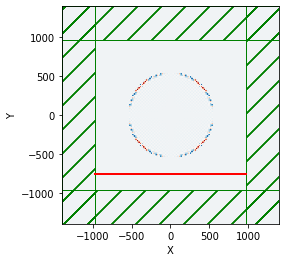

In [10]:
from tqdm import tqdm

results = []
for h in tqdm([4,8,12,14,16,20]):
    results.append(simulate(h=h, t_steps=100000))

In [11]:
from IPython.display import display
for res in results:
    print('h = ',res['h'])
    try:
        display(Video(res['animfname']))
    except Error as e:
        print(e)
        print('Unstable?')

h =  4


h =  8


h =  12


h =  14


h =  16


h =  20
